In [13]:
## Train

import torch
from transformers import BertTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments

# Replace these lists with your actual dataset
# sentences = ["This is an example sentence from my domain.", "Another example sentence from my domain."]
from utils import load_train_eval_data

# Among the original training data, 75% is used for training, 25% is used for validation
train_prop = 0.75

## Hyperparameters 
# Set the fine-tuning type 
train_type = "shakestrain" # One of ["sonnets", "shakestrain", "poems"]

multimodal = False
save_steps = 1
num_epochs = 1
lr = 2e-5

# Hyperparams for continue training with checkpoint 
continue_with_checkpoint = False
checkpoint_iter = 626 # Change this to change which checkpoint to load
num_finished_epochs = 2
num_finished_iter = 600



train_set, val_set = load_train_eval_data(train_type, multimodal, train_prop)



# if continue_with_checkpoint: 
#     checkpoint_iter = 15300 # Change this to change which checkpoint to load
#     num_remaining_epochs = 4
#     # Load the tokenizer and the pre-trained model
#     tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#     model = BertForMaskedLM.from_pretrained(f"./results_prev/checkpoint-{checkpoint_iter}/")

#     # Set up the data collator
#     data_collator = DataCollatorForLanguageModeling(
#         tokenizer=tokenizer, mlm=True, mlm_probability=0.15
#     )
#     training_args = torch.load(f"./results_prev/checkpoint-{checkpoint_iter}/training_args.bin"),
#     print(list(training_args))
    
    
#     STOP
    
#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_set,
#         eval_dataset=val_set,
#         data_collator=data_collator,
#     )
# else:
# Load the tokenizer and the pre-trained model

if train_type == "poems":
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertForMaskedLM.from_pretrained("bert-base-uncased")
elif train_type == "sonnets":
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertForMaskedLM.from_pretrained(f"./final_model_poems/")
elif train_type == "shakestrain":
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertForMaskedLM.from_pretrained(f"./final_model_sonnets/")
    
# Set up the data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

print(f"Training data type: {train_type}")

# Set up the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=100,
    logging_dir="./logs",
    logging_steps=1,
    save_steps=save_steps,
    seed=42,
    learning_rate=lr,
    weight_decay=0.01,
)

# Create the Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=val_set,
    data_collator=data_collator,
)
    
    
# Fine-tune the model
if continue_with_checkpoint:
    trainer.train(f"./results/checkpoint-{checkpoint_iter}/")
else:
    trainer.train()

torch.save(model, "model.pth")

Found cached dataset text (C:/Users/Shaobo Liang/.cache/huggingface/datasets/text/default-bc56bdd3f34ac779/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\Shaobo Liang\.cache\huggingface\datasets\text\default-bc56bdd3f34ac779\0.0.0\cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2\cache-3cf87725739e320a.arrow
Loading cached processed dataset at C:\Users\Shaobo Liang\.cache\huggingface\datasets\text\default-bc56bdd3f34ac779\0.0.0\cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2\cache-fdd9299b36bddbb3.arrow


Training data type: shakestrain


F:\Programs\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,4.407600,3.462591
2,2.830200,2.722194
3,3.165400,2.401299
4,1.949400,2.139656
5,2.613300,2.076283
6,1.454500,1.927386
7,2.314700,1.944210
8,2.274700,1.797179
9,1.713600,1.820084
10,2.005100,1.740298


In [15]:
## Save the latest model

output_dir = "./saved_model"
model.save_pretrained(output_dir)

In [16]:
## Print test results for the current saved model (last iteration)

from test import test_main

model_path = "./saved_model/"

k = 5 # I want top 5 test metrics

results_dict = test_main(model_path, k)

print(f"Top {k} accuracy is {results_dict['accuracy']}.")
print(f"Top {k} cosine similarity score is {results_dict['cos_sim']}.")
# print(f"Top {k} rhyming score is {results_dict["rhyme"]}.") # To be implemented




Top 5 accuracy is 0.2520107238605898.
Top 5 cosine similarity score is 0.5264520645141602.


In [17]:
## Save all checkpoitn test results for current iteration. 

import json


## Hyperparams
total_iters_per_eph = 12
prev_log_name = "acc_cos_log_lr5e-6_2epoch" #  This is for continuing with checkpoint 
num_saved_models = int(total_iters_per_eph * num_epochs / save_steps)
num_start_iter = num_finished_iter + save_steps  # The starting iteration of this training round here 


# Obtain list of test results for every checkpoint 
acc_arr = []
cos_arr = []

if continue_with_checkpoint:
    with open(f"./results/{prev_log_name}.json", "r") as openfile:
        json_object = json.load(openfile)
    acc_arr = json_object["acc_arr"]
    cos_arr = json_object["cos_arr"]
    
    for i in range(num_saved_models - num_start_iter):
        model_path = f"./results/checkpoint-{save_steps * (i + 1 + num_start_iter)}/"

        k = 5 # I want top 5 test metrics

        results_dict = test_main(model_path, k)

        print(f"Checkpoint {save_steps * (i+1+num_start_iter)}")
        print(f"Top {k} accuracy is {results_dict['accuracy']}.")
        print(f"Top {k} cosine similarity score is {results_dict['cos_sim']}.")

        acc_arr.append(results_dict['accuracy'])
        cos_arr.append(results_dict['cos_sim'])    
else:
    for i in range(num_saved_models):
        model_path = f"./results/checkpoint-{save_steps * (i + 1)}/"

        k = 5 # I want top 5 test metrics

        results_dict = test_main(model_path, k)

        print(f"Checkpoint {save_steps * (i+1)}")
        print(f"Top {k} accuracy is {results_dict['accuracy']}.")
        print(f"Top {k} cosine similarity score is {results_dict['cos_sim']}.")

        acc_arr.append(results_dict['accuracy'])
        cos_arr.append(results_dict['cos_sim'])
    

Checkpoint 10
Top 5 accuracy is 0.22788203753351208.
Top 5 cosine similarity score is 0.5138329863548279.
Checkpoint 20
Top 5 accuracy is 0.2386058981233244.
Top 5 cosine similarity score is 0.5197867751121521.
Checkpoint 30
Top 5 accuracy is 0.2386058981233244.
Top 5 cosine similarity score is 0.5196592807769775.
Checkpoint 40
Top 5 accuracy is 0.24128686327077747.
Top 5 cosine similarity score is 0.5208036303520203.
Checkpoint 50
Top 5 accuracy is 0.24396782841823056.
Top 5 cosine similarity score is 0.5222459435462952.
Checkpoint 60
Top 5 accuracy is 0.2386058981233244.
Top 5 cosine similarity score is 0.5189563632011414.
Checkpoint 70
Top 5 accuracy is 0.24128686327077747.
Top 5 cosine similarity score is 0.5188159942626953.
Checkpoint 80
Top 5 accuracy is 0.24396782841823056.
Top 5 cosine similarity score is 0.5219241976737976.
Checkpoint 90
Top 5 accuracy is 0.24664879356568364.
Top 5 cosine similarity score is 0.5230903625488281.
Checkpoint 100
Top 5 accuracy is 0.24396782841823

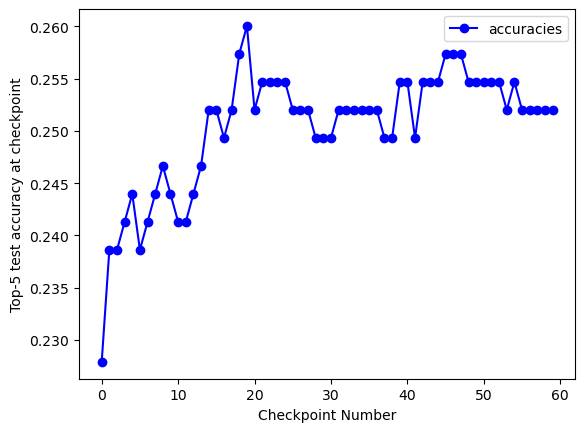

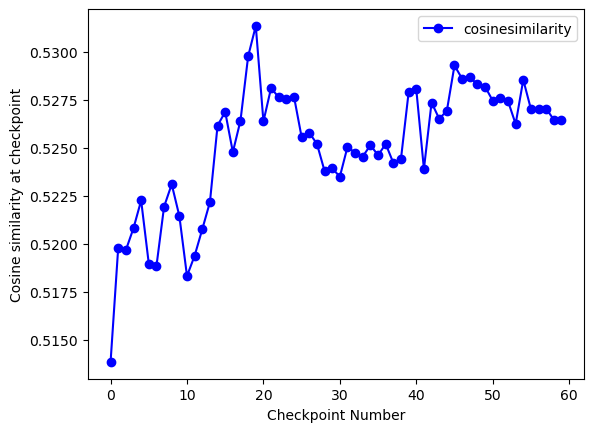

In [18]:
## Plot all test results using json log

import matplotlib
import matplotlib.pyplot as plt

plt.plot(acc_arr, '-o', label = 'accuracies', color = 'blue')
plt.xlabel('Checkpoint Number')
plt.ylabel('Top-5 test accuracy at checkpoint')
plt.legend()
plt.show()

plt.plot(cos_arr, '-o', label = 'cosinesimilarity', color = 'blue')
plt.xlabel('Checkpoint Number')
plt.ylabel('Cosine similarity at checkpoint')
plt.legend()
plt.show()

In [19]:
## Save log to text file

array_log = open("acc_cos_log.txt", "w")

array_log.write(str(acc_arr))
array_log.write(str("\n\n"))
array_log.write(str(cos_arr))

array_log.close()

In [20]:
## Save log to json file

import json

cos_arr_list = []

# if continue_with_checkpoint:
for i in range(len(cos_arr)):
    if type(cos_arr[i]) == float:
        cos_arr_list.append(cos_arr[i])
    else:
        cos_arr_list.append(cos_arr[i].item())
# else: 
#     for i in range(len(cos_arr)):
#         cos_arr_list.append(cos_arr[i].item())
    
arrays_dict = {
    "acc_arr": acc_arr,
    "cos_arr": cos_arr_list
}

json_object = json.dumps(arrays_dict)

with open("acc_cos_log.json", "w") as outfile:
    outfile.write(json_object)

In [21]:
## Print the iteration with the highest accuracy and cosine similarity

max_acc = 0
num_max_acc_iter = 0
max_cos = 0
num_max_cos_iter = 0

for i in range(len(acc_arr)):
    if acc_arr[i] > max_acc:
        max_acc = acc_arr[i]
        num_max_acc_iter = save_steps * (i + 1)
    if cos_arr[i] > max_cos:
        max_cos = cos_arr[i]
        num_max_cos_iter = save_steps * (i + 1)

if acc_arr[int(num_max_acc_iter/save_steps)-1] == acc_arr[int(num_max_cos_iter/save_steps)-1]:
    num_max_acc_iter = num_max_cos_iter
        
print(f"Max Acc: {max_acc}")
print(f"Max Acc Iter: {num_max_acc_iter}")
print()
print(f"Max Cos: {max_cos}")
print(f"Max Cos Iter: {num_max_cos_iter}")

Max Acc: 0.26005361930294907
Max Acc Iter: 200

Max Cos: 0.5313428044319153
Max Cos Iter: 200
